# Multisectoral energy system with oemof

### General description:

The jupyter notebook gives a simple example of how to couple the sectors power, heat and mobility.

### Installation requirements:

This example requires the latest oemof version and jupyter. Install by:

    pip install oemof jupyter

## Create a simple energy system

![A simple energy system.](images/simple_system.png "Well, this is simple.")

### Initialize energy system

In [1]:
from oemof.solph import EnergySystem
import pandas as pd

# initialize energy system
energysystem = EnergySystem(timeindex=pd.date_range('1/1/2016', 
                                                    periods=168, 
                                                    freq='H'))

### Import input data

In [2]:
# import example data with scaled demands and feedin timeseries of renewables 
# as dataframe
data = pd.read_csv("data/example_data.csv", sep=",", index_col='timeindex', parse_dates=['timeindex'])

### Add entities to energy system

In [3]:
from oemof.solph import Bus, Flow, Sink, Source, Transformer

### BUS
# create electricity bus
b_el = Bus(label="b_el")
energysystem.add(b_el)

# add excess sink to help avoid infeasible problems
energysystem.add(Sink(label="excess_el",
                      inputs={b_el: Flow()}))
energysystem.add(Source(label="shortage_el",
                        outputs={b_el: Flow(variable_costs=1000)}))

### DEMAND
# add electricity demand
energysystem.add(Sink(label="demand_el",
                      inputs={b_el: Flow(nominal_value=85,
                                         actual_value=data['demand_el'],
                                         fixed=True)}))

### SUPPLY
# add wind and pv feedin
energysystem.add(Source(label="wind",
                        outputs={b_el: Flow(actual_value=data['wind'],
                                            nominal_value=60,
                                            fixed=True)}))
energysystem.add(Source(label="pv",
       outputs={b_el: Flow(actual_value=data['pv'],
                           nominal_value=200,
                           fixed=True)}))


### Optimize energy system and plot results

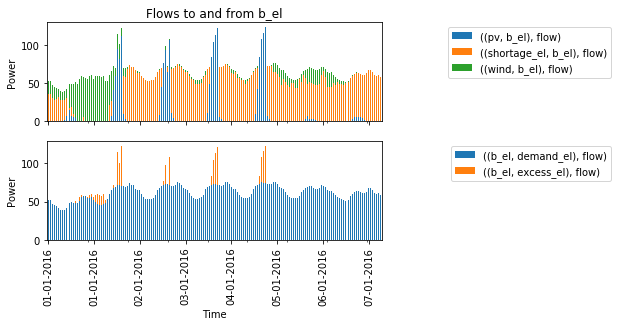

In [5]:
from oemof.solph import Model
from oemof.outputlib import processing, views
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def optimize(energysystem):
    
    ### optimize
    # create operational model
    om = Model(energysystem=energysystem)

    # solve using the cbc solver
    om.solve(solver='cbc',
             solve_kwargs={'tee': False})

    # save LP-file
    om.write('sector_coupling.lp', io_options={'symbolic_solver_labels': True})

    # generic result object
    #results = processing.results(om=om)

    return om


def plot(om, bus_label):
    """
    Plots...

    Parameters
    ----------
    om : oemof.solph.models.OperationalModel
    bus_label : String
        Label of bus to be plotted.
    """
    
    #ToDo: remove this once #387 is solved
    def get_flows_to_and_from_bus(node_results_flows):
        "Function to devide flows into ingoing and outgoing flows."
        flows = list(node_results_flows.columns)
        to_flows = []
        from_flows = []
        for flow in flows:
            if flow[0][0] == bus_label:
                from_flows.append(flow)
            elif flow[0][1] == bus_label:
                to_flows.append(flow)
            else:
                print("{} is neither from nor to bus.".format(flow))
        return (to_flows, from_flows)

    # node_results is a dictionary keyed by 'scalars' and 'sequences'
    # holding respective data in a pandas Series and DataFrame.
    node_results = views.node(om.results(), bus_label)
    node_results_flows = node_results['sequences']
    to_flows, from_flows = get_flows_to_and_from_bus(node_results_flows)

    # set up plot
    f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
    node_results_flows[to_flows].plot(kind='bar', stacked=True, ax=ax1)
    node_results_flows[from_flows].plot(kind='bar', stacked=True, ax=ax2)

    ax1.set_title('Flows to and from {}'.format(bus_label))
    ax1.legend(loc='upper right', bbox_to_anchor=(1.7, 1.0))
    ax2.legend(loc='upper right', bbox_to_anchor=(1.7, 1.0))
    ax1.set_ylabel('Power')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Power')
    
    # set x-tick-labels
    dates = node_results_flows.index
    tick_distance = int(len(dates) / 7) - 1
    ax2.set_xticks(range(0, len(dates), tick_distance), minor=False)
    ax2.set_xticklabels([item.strftime('%d-%m-%Y')
         for item in dates.tolist()[0::tick_distance]],
         rotation=90, minor=False)

    plt.show()
    
om = optimize(energysystem)
plot(om, 'b_el')

## Adding the gas sector

![A simple energy system with a gas power plant.](images/gas_pp.png "Now, this doesn't look so simple anymore.")

In order to add a gas power plant, a gas ressource bus is needed. The gas power plant connects the gas and electricity busses and thereby couples the gas and electricity sector.

In [6]:
# add gas bus
b_gas = Bus(label="b_gas",
            balanced=False)
energysystem.add(b_gas)

# add gas power plant
energysystem.add(Transformer(label="pp_gas",
                             inputs={b_gas: Flow(summed_max_flow=200)},
                             outputs={b_el: Flow(nominal_value=40,
                                                 variable_costs=40)},
                             conversion_factors={b_el: 0.50}));

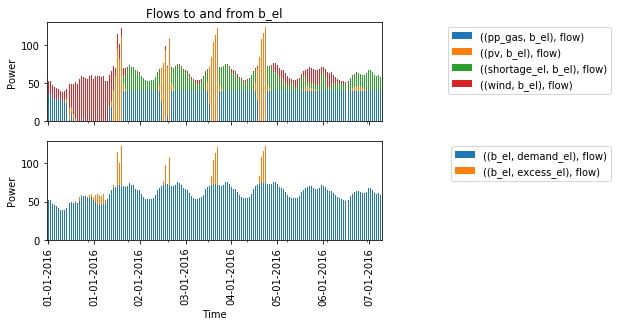

In [7]:
om = optimize(energysystem)
plot(om, 'b_el')

## Adding the heat sector

![The energy system, now with some heat.](images/heat.png "Bring on the heat.")

The heat sector is added and coupled to the electricity sector similarly to the gas sector. The same component, the LinearTransformer, is used to couple the two sectors. Only through its parametrisation it becomes a heater rod or a heat pump.


In [8]:
# add heat bus
b_heat = Bus(label="b_heat",
             balanced=True)
energysystem.add(b_heat)

# add heat demand
energysystem.add(Sink(label="demand_th",
                      inputs={b_heat: Flow(nominal_value=60,
                                           actual_value=data['demand_th'],
                                           fixed=True)}))

# add heater rod
energysystem.add(Transformer(label="heater_rod",
                             inputs={b_el: Flow()},
                             outputs={b_heat: Flow(variable_costs=10)},
                             conversion_factors={b_heat: 0.98}));

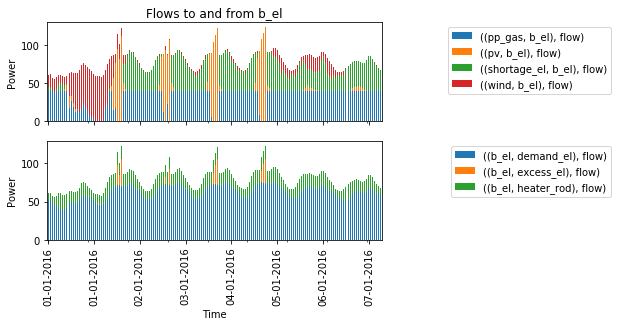

In [9]:
om = optimize(energysystem)
plot(om, 'b_el')

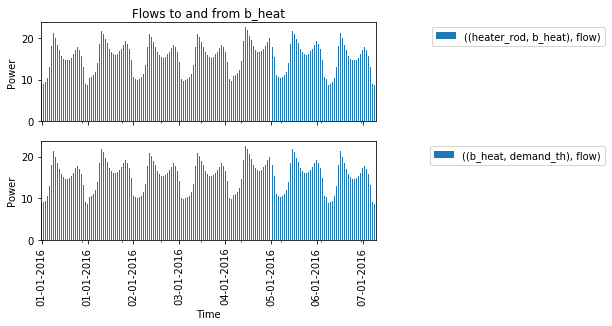

In [10]:
plot(om, 'b_heat')

### Adding a heat pump

There are different ways to model a heat pump. Here the approach of precalculating a COP and using this as a conversion factor for the LinearTransformer is used. Another approach is to use the LinearN1Transformer that has two inputs - electricity and heat from a heat source. See the solph example "simple_dispatch".

In [11]:
# COP can be calculated beforehand, assuming the heat reservoir temperature 
# is infinite random timeseries for COP
import numpy as np
COP = np.random.uniform(low=3.0, high=5.0, size=(168,))

# add heater rod
#Transformer(label="heater_rod",
#            inputs={b_el: Flow()},
#            outputs={b_heat: Flow(variable_costs=10)},
#            conversion_factors={b_heat: 0.98});

# add heat pump
energysystem.add(Transformer(label="heat_pump",
                             inputs={b_el: Flow()},
                             outputs={b_heat: Flow(nominal_value=20,
                                                   variable_costs=10)},
                             conversion_factors={b_heat: COP}));

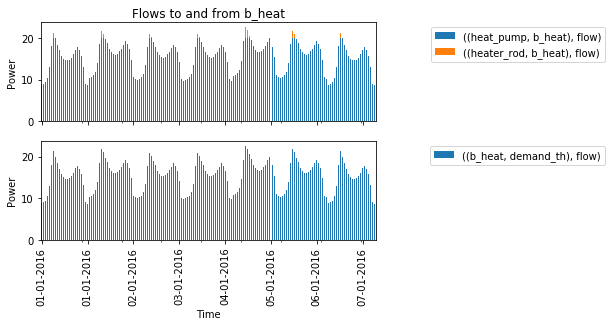

In [12]:
om = optimize(energysystem)
plot(om, 'b_heat')

### Adding a combined heat and power plant

![All new, now with a CHP.](images/combined_heat_and_power.png 'CHP rolls off the tongue so much better than "combined heat and power".')

The combined heat and power plant couples the gas, electricity and heat sector.

In [13]:
# add CHP with fixed ratio of heat and power (back-pressure turbine)
energysystem.add(Transformer(label='pp_chp',
                             inputs={b_gas: Flow()},
                             outputs={b_el: Flow(nominal_value=30,
                                                 variable_costs=42),
                                      b_heat: Flow(nominal_value=40)},
                             conversion_factors={b_el: 0.3,
                                                 b_heat: 0.4}));

In [14]:
from oemof.solph.components import ExtractionTurbineCHP

# add CHP with variable ratio of heat and power (extraction turbine)
energysystem.add(ExtractionTurbineCHP(label='pp_chp_extraction',
                                      inputs={b_gas: Flow()},
                                      outputs={b_el: Flow(nominal_value=30,
                                                          variable_costs=42),
                                               b_heat: Flow(nominal_value=40)},
                                      conversion_factors={b_el: 0.3,
                                                          b_heat: 0.4},
                                      conversion_factor_full_condensation={b_el: 0.5}));

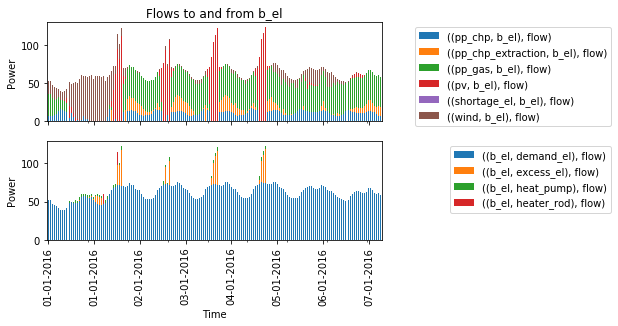

In [15]:
om = optimize(energysystem)
plot(om, 'b_el')

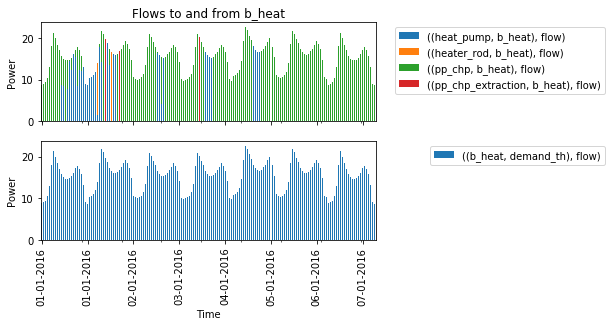

In [16]:
om = optimize(energysystem)
plot(om, 'b_heat')

## Adding the mobility sector

![Making it mobile.](images/mobility.png "Mobility? I don't think this thing is going anywhere anymore.")

In [17]:
from oemof.solph.components import GenericStorage as Storage

charging_power = 20
bev_battery_cap = 50

# add mobility bus
b_bev = Bus(label="b_bev",
            balanced=True)
energysystem.add(b_bev)

# add transformer to transport electricity from grid to mobility sector
energysystem.add(Transformer(label="transport_el_bev",
                             inputs={b_el: Flow()},
                             outputs={b_bev: Flow(variable_costs=10,
                                                  nominal_value=charging_power,
                                                  max=data['bev_charging_power'])},
                             conversion_factors={b_bev: 1.0}))
    
# add BEV storage
energysystem.add(Storage(label='bev_storage',
                 inputs={b_bev: Flow()},
                 outputs={b_bev: Flow()},
                 nominal_capacity=bev_battery_cap,
                 capacity_min=data['bev_cap_min'],
                 capacity_max=data['bev_cap_max'],
                 capacity_loss=0.00,
                 initial_capacity=None,
                 inflow_conversion_factor=1.0,
                 outflow_conversion_factor=1.0,
                 nominal_input_capacity_ratio=1.0,
                 nominal_output_capacity_ratio=1.0))

# add sink for leaving vehicles
energysystem.add(Sink(label="leaving_bev",
                      inputs={b_bev: Flow(nominal_value=bev_battery_cap,
                                          actual_value=data['bev_sink'],
                                          fixed=True)}))

# add source for returning vehicles
energysystem.add(Source(label="returning_bev",
                        outputs={b_bev: Flow(nominal_value=bev_battery_cap,
                                             actual_value=data['bev_source'],
                                             fixed=True)}));

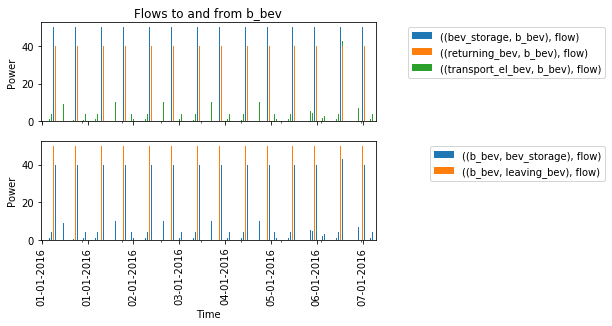

In [18]:
om = optimize(energysystem)
plot(om, 'b_bev')

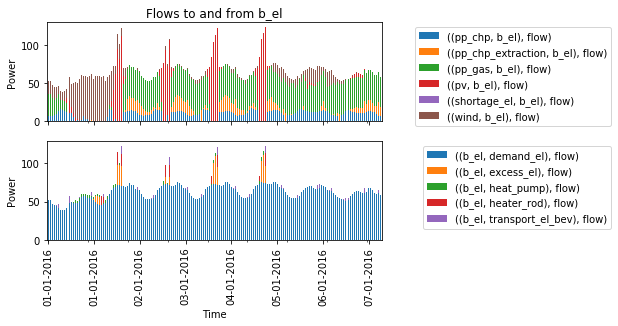

In [19]:
plot(om, 'b_el')